# 03 - Decompose Travel Time with `wmatarawnav`

This notebook illustrates how the `wmatarawnav` package and methods developed for the WMATA Analysis of Fine-Grained Bus AVL to Evaluate Queue Jump Effectiveness study (Queue Jump Effectiveness study) can be used to decompose travel time within an evaluation segment. This decomposition can then be used to evaluate the effectiveness of infrastructure in reducing vehicle travel time. This notebook will not provide a conceptual overview of the travel time decomposition method used in the Queue Jump Effectiveness Study, but rather explain how this methodology is implemented through the `wmatarawnav` package.

As before, code for this project exists in two general forms:
1. **Code usable for any analysis of rawnav data.** Functions for relating rawnav data to other sources are contained in the in-development Python package `wmatarawnav`.
2. **Code specific to the Queue Jump Effectiveness study**. This code contains project-specific steps to relate rawnav data to other data using functions in the `wmatarawnav` package along the way. 

In this notebook, code usable for any analysis of rawnav data are illustrated using the custom functions contained in the `wmatarawnav` package. The actual process used for the Queue Jump Effectiveness study will differ slightly in form, but still makes use of these general steps.

The contents of this notebook include:

1. Environment Setup
2. Reload Processed Data
3. Decompose Travel Time
    a. Calculate Freeflow Speed
    b. Decompose Stop Area Movements
    c. Decompose Travel Time

## 1. Environment Setup

We begin by importing dependencies required for this notebook and the wmatarawnav package using `import wmatarawnav as wr`.

In [28]:
import os, sys, glob, pandas as pd, geopandas as gpd
import pyarrow as pa, pyarrow.parquet as pq

sys.path.append('../..')
path_demo_data = os.path.join("../../data/00-raw/demo_data")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%load_ext autoreload
%autoreload 2
    
wmata_crs = 2248

import wmatarawnav as wr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Reload Processed Data

We'll illustrate the steps to decompose travel time in a northbound segment at 16th St & U St NW. To limit the size of the data used, we'll focus on Route S9 for Wednesdays in October 2017. An image of the segment is shown below.

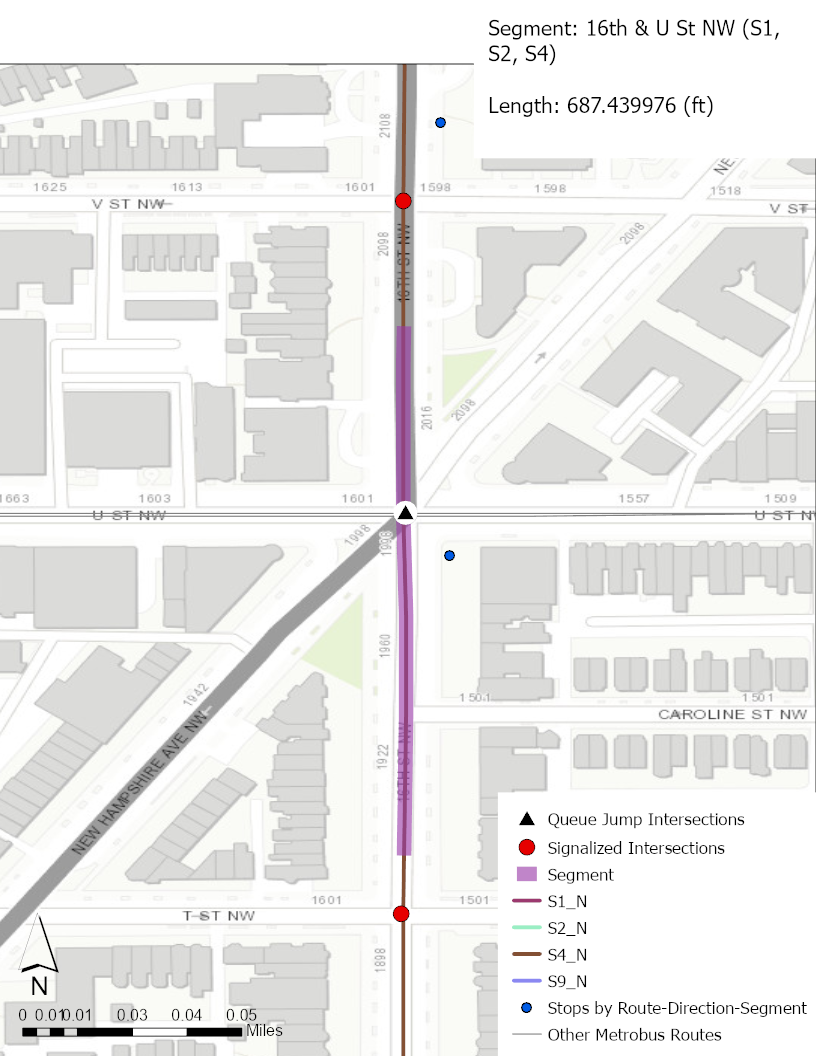

In practice, in cases where there are multiple segments and routes to be evaluated, the process of reloading code would be more complex, involving iteration over . Data is reloaded based on the name of the segment (called 'sixteenth_u_stub' here) and a crosswalk linking route patterns to a segment. These are shown in the chunk below.

In [3]:
pattern_stop = (
    pd.DataFrame(
        {'route':['S9'],
         'pattern':[2], 
         'seg_name_id':['sixteenth_u_stub'],
         'stop_id' : [18042]}
    )
)

pattern_stop

,route,pattern,seg_name_id,stop_id
0,S9,2,sixteenth_u_stub,18042


Data will be reloaded from Parquet files as described in the previous vignette. `wr.read_cleaned_rawnav` is a wrapper around parquet read-in functions with specific advantages for rawnav data.

In [5]:
rawnav_dat = (
    wr.read_cleaned_rawnav(
        analysis_routes_= ['S9'],
        path = os.path.join(
            path_demo_data,
            "03_notebook_data",
            "rawnav_data.parquet"
        )
    )
)

Segment data can be reloaded directly from Parquet. Note that at this point we remove runs that do not meet basic criteria. This includes runs that: 

1. Do not have rawnav pings near segment endpoints.
2. Do not have odometer readings within the segment that are compatible with the segment length.
3. Do not reach the start and end of the segment in the correct order. 

The remaining table of segments will be used to subset rawnav data, among other purposes.

In [6]:
# Note: In practice, a filter here would specify the seg_name_id of the segment data to be loaded.
segment_summary = (
    pq.read_table(
        source = os.path.join(
            path_demo_data,
            "03_notebook_data",
            "segment_summary.parquet"
        ),
        use_pandas_metadata = True)
    .to_pandas()
)

segment_summary_fil = (
    segment_summary
    .query('~(flag_too_far_any | flag_wrong_order_any | flag_too_long_odom)')
)

The rawnav ping nearest to each stop is stored as an index table separate from the rawnav data itself. This table is immediately filtered to the stop(s) listed in the `pattern_stops` table. For clarity, we've renamed the field `odom_ft_qj_stop`. This is the odometer reading of the vehicle as it passes nearest to the stop. This value will later be used to define an area around the stop. 

In [8]:
# Note: In practice, iteration would only reload the data of routes associated with the given segment.
stop_index = (
            pq.read_table(
                source = os.path.join(
                    path_demo_data,
                    "03_notebook_data",
                    "stop_index.parquet"
                ),
                columns = ['seg_name_id',
                           'route',
                           'pattern',
                           'stop_id',
                           'filename',
                           'index_run_start',
                           'index_loc',
                           'odom_ft',
                           'sec_past_st',
                           'geo_description']
            )
            .to_pandas()
            .assign(pattern = lambda x: x.pattern.astype('int32')) 
            .rename(columns = {'odom_ft' : 'odom_ft_qj_stop'})
    ) 

stop_index_fil = (
    stop_index
    .merge(pattern_stop,
           on = ['route','pattern','stop_id'],
           how = 'inner')   
)

stop_index_fil.head()

,pattern,stop_id,filename,index_run_start,index_loc,odom_ft_qj_stop,sec_past_st,geo_description,route,wday,seg_name_id
0,2,18042,rawnav06424171005.txt,1980.0,2303.0,7237.0,627.0,16TH ST + U ST,S9,Wednesday,sixteenth_u_stub
1,2,18042,rawnav06424171005.txt,5317.0,5651.0,7236.0,588.0,16TH ST + U ST,S9,Wednesday,sixteenth_u_stub
2,2,18042,rawnav06424171005.txt,8246.0,8543.0,7310.0,581.0,16TH ST + U ST,S9,Wednesday,sixteenth_u_stub
3,2,18042,rawnav06424171005.txt,11158.0,11451.0,7272.0,582.0,16TH ST + U ST,S9,Wednesday,sixteenth_u_stub
4,2,18042,rawnav06424171005.txt,14238.0,14539.0,7262.0,716.0,16TH ST + U ST,S9,Wednesday,sixteenth_u_stub


While other tables are produced during the processing stage (segment index, stop-based summary), at this point in an analysis these tables are no longer needed.

## 3. Decompose Travel Time
### 3A. Calculate Freeflow Speed

The freeflow speed is the 95th percentile speed observed *between three sequential rawnav pings* within a segment over all available runs. Note that this is different from the 95th percentile speed over the *entire* segment. An example will illustrate:

1. A run has 10 rawnav pings in a segment from 1 to 10.
2. Between ping 1 and ping 4, the bus travels 20 feet in 3 seconds for a speed of 6.67 feet per second; between ping 2 and ping 5, the bus travels 30 feet in 2 seconds for a speed of 15 feet per second, and so forth.
3. The 95th percentile values of these speeds (6.67 fps, 15 fps, etc.) across all runs is used to determine the freeflow speed of the segment.

This method is especially suited for longer segments that may include multiple signalized intersections. By examining these short instances within a segment, the resulting 95th percentile speed will not reflect the effects of slowing to a stop at downstream signalized intersections or stops. Instead, 95th percentile speeds are likely to be closer to the top speeds observed between signalized intersections. In practice, the freeflow speed over a segment including several signalized intersections and wide streets would be approximately 30 mph (near the speed limit) while the freeflow speed over a shorter segment with few lanes may be closer to 20 mph.

For effective use of the freeflow calculation, a large volume of runs across any applicable routes in a segment should be used. For the purposes of this notebook, only Wednesday data for S9, a MetroExtra route with a more restricted span of service than some other S routes, is used. This may result in a freeflow speed less reflective of conditions in the segment.

Each percentile of speeds for this segment is shown below, with `fps_next3` representing the feet per second speed between a rawnav ping and the next three pings and `mph` representing the same figure converted to miles per hour. Only the 95th percentile value will be used in subsequent calculations.

In [23]:
segment_ff = (
    wr.decompose_segment_ff(
        rawnav_dat,
        segment_summary_fil,
        max_fps = 73.3
    )
    .assign(seg_name_id = 'sixteenth_u_stub')
)

(
    segment_ff
    .round()
    .reset_index()
    .rename(columns = {'index':'percentile'})
)

,percentile,fps_next3,mph,seg_name_id
0,0.01,0.0,0.0,sixteenth_u_stub
1,0.05,2.0,1.0,sixteenth_u_stub
2,0.10,5.0,3.0,sixteenth_u_stub
3,0.15,9.0,6.0,sixteenth_u_stub
4,0.25,14.0,10.0,sixteenth_u_stub
5,0.50,25.0,17.0,sixteenth_u_stub
6,0.75,35.0,24.0,sixteenth_u_stub
7,0.85,39.0,27.0,sixteenth_u_stub
8,0.90,42.0,28.0,sixteenth_u_stub
9,0.95,45.0,31.0,sixteenth_u_stub


Note also:

* This freeflow value is recorded as a speed, rather than a travel time. Though the length of the segment does not change between runs, the rawnav ping nearest to the segment start and end point will differ slightly by run. Therefore, this freeflow speed will later be applied to a segment distance that varies slightly by run to calculate a freeflow travel time by run. 
* The use of subsequent pings for calculation does not extend past the end of the segment. In other words, the `fps_next3` value for the second to last rawnav ping will be a NA value because there are not three subsequent pings for that ping. 

### 3B. Decompose Stop Area Movements

The travel time decomposition pays special consideration to activity around a stop, namely:

* The time spent with doors open serving passengers (t_stop1)
* The estimated time to serve a stop independent of other delay (t_stop2)

Calculation of these values requires a decomposition of stop area movements in order to retrieve values that can be used in the decomposition of travel time.

The function `decompose_stop_area` returns rawnav data for each run within +/- 150 feet of the stop, along with additional columns describing the phase of movement a vehicle is in.

In [25]:
stop_area_decomp = (
    wr.decompose_stop_area(
        rawnav_dat,
        segment_summary_fil,
        stop_index_fil
    )
    .assign(seg_name_id = 'sixteenth_u_stub')
)

For the purposes of illustration, stop area movement decomposition data for one run will be shown. Again, runs are uniquely identified by `filename` (e.g., "rawnav06424171012.txt") and `index_run_start` (e.g., 4748, the index value of the first record for the run in cleaned data).

In [45]:
case_file = "rawnav06424171012.txt"
case_run = 4748

case_data = (
    stop_area_decomp
    .query('filename == @case_file & index_run_start == @case_run')
    .filter(
        items = [
            'index_loc',
            'heading',
            'door_state',
            'odom_ft',
            'sec_past_st',
            'odom_ft_qj_stop',
            'secs_marg',
            'odom_ft_marg',
            'fps_next',
            'fps_next3',
            'stop_area_phase'
        ]
    )
)


Only selected columns are shown to begin. Note:
* **door_state** is either "C" (Closed) or "O" (Open).
* **odom_ft** is the odometer reading at each rawnav ping, and **odom_ft_qj_stop** is the odometer reading of the ping nearest to the QJ stop. As shown here, at 7,711 feet, this ping is slightly further upstream than where the bus in fact opened its doors to passengers at 7,738 feet. In practice, this difference is not material -- the reading at 7,711 feet is used to define the stop area 150 feet upstream and downstream from the stop (the data shown here) and is not used afterwards.
* **secs_marg** and **odom_ft_marg** are used to show the marginal value between the current observation and the next one. Similarly, the speed over the interval based on these values is **fps_next**. **fps_next3** (the speed between the current ping and the ping 3 observations ahead) is not used here, but is provided for context for later discussions.
* **stop_area_phase** is the key output of the stop area decomposition, and will be discussed further below.

In [46]:
case_data

,index_loc,heading,door_state,odom_ft,sec_past_st,odom_ft_qj_stop,secs_marg,odom_ft_marg,fps_next,fps_next3,stop_area_phase
119,5121.0,5.0,C,7567.0,913.0,7711.0,1.0,27.0,27.000000,24.333333,t_decel_phase
120,5122.0,3.0,C,7594.0,914.0,7711.0,1.0,26.0,26.000000,25.666667,t_decel_phase
121,5123.0,2.0,C,7620.0,915.0,7711.0,1.0,20.0,20.000000,24.333333,t_decel_phase
122,5124.0,2.0,C,7640.0,916.0,7711.0,1.0,31.0,31.000000,23.666667,t_decel_phase
123,5125.0,2.0,C,7671.0,917.0,7711.0,1.0,22.0,22.000000,18.000000,t_decel_phase
124,5126.0,6.0,C,7693.0,918.0,7711.0,1.0,18.0,18.000000,11.250000,t_decel_phase
125,5127.0,7.0,C,7711.0,919.0,7711.0,1.0,14.0,14.000000,4.500000,t_decel_phase
126,5128.0,5.0,C,7725.0,920.0,7711.0,2.0,13.0,6.500000,0.764706,t_decel_phase
127,5129.0,3.0,C,7738.0,922.0,7711.0,3.0,0.0,0.000000,0.000000,t_l_initial
128,5130.0,3.0,O,7738.0,925.0,7711.0,12.0,0.0,0.000000,0.000000,t_stop1


In [42]:
stop_area_decomp.head()

,index,index_loc,lat,long,heading,door_state,veh_state,odom_ft,sec_past_st,sat_cnt,stop_window,blank,lat_raw,long_raw,row_before_apc,route_pattern,pattern,index_run_start,index_run_end,filename,start_date_time,route,wday,odom_ft_next,sec_past_st_next,odom_ft_next3,sec_past_st_next3,odom_ft_qj_stop,stop_id,secs_marg,odom_ft_marg,fps_next,fps_next3,door_state_closed,veh_state_moving,door_state_changes,veh_state_changes,door_state_changes_min,door_state_changes_max,veh_stopped_min,veh_stopped_max,any_door_open,any_veh_stopped,rough_phase_by_door,rough_phase_by_veh_state,at_stop,at_stop_phase,stop_area_phase,seg_name_id
0,8,2296.0,38.916325,-77.036503,1.0,C,M,7090.0,621.0,7.0,,2.0,38.916252,-77.036505,0.0,S902,2,1980.0,3409.0,rawnav06424171005.txt,2017-10-04 07:39:47,S9,Wednesday,7117.0,622.0,7168.0,623.0,7237.0,18042.0,1.0,27.0,27.0,39.000000,True,True,1,1.0,2.0,2.0,2.0,2.0,True,True,t_decel_phase,t_decel_phase,False,NA,t_decel_phase,sixteenth_u_stub
1,9,2297.0,38.916399,-77.036499,2.0,C,M,7117.0,622.0,6.0,,2.0,38.916325,-77.036503,0.0,S902,2,1980.0,3409.0,rawnav06424171005.txt,2017-10-04 07:39:47,S9,Wednesday,7144.0,623.0,7193.0,624.0,7237.0,18042.0,1.0,27.0,27.0,38.000000,True,True,1,1.0,2.0,2.0,2.0,2.0,True,True,t_decel_phase,t_decel_phase,False,NA,t_decel_phase,sixteenth_u_stub
2,10,2298.0,38.916473,-77.036494,2.0,C,M,7144.0,623.0,7.0,,2.0,38.916399,-77.036499,0.0,S902,2,1980.0,3409.0,rawnav06424171005.txt,2017-10-04 07:39:47,S9,Wednesday,7168.0,623.0,7195.0,625.0,7237.0,18042.0,0.0,24.0,inf,25.500000,True,True,1,1.0,2.0,2.0,2.0,2.0,True,True,t_decel_phase,t_decel_phase,False,NA,t_decel_phase,sixteenth_u_stub
3,11,2299.0,38.916545,-77.036488,3.0,C,M,7168.0,623.0,7.0,,2.0,38.916473,-77.036494,0.0,S902,2,1980.0,3409.0,rawnav06424171005.txt,2017-10-04 07:39:47,S9,Wednesday,7193.0,624.0,7217.0,626.0,7237.0,18042.0,1.0,25.0,25.0,16.333333,True,True,1,1.0,2.0,2.0,2.0,2.0,True,True,t_decel_phase,t_decel_phase,False,NA,t_decel_phase,sixteenth_u_stub
4,12,2300.0,38.916615,-77.036481,4.0,C,M,7193.0,624.0,6.0,,2.0,38.916545,-77.036488,0.0,S902,2,1980.0,3409.0,rawnav06424171005.txt,2017-10-04 07:39:47,S9,Wednesday,7195.0,625.0,7237.0,627.0,7237.0,18042.0,1.0,2.0,2.0,14.666667,True,True,1,1.0,2.0,2.0,2.0,2.0,True,True,t_decel_phase,t_decel_phase,False,NA,t_decel_phase,sixteenth_u_stub


The possible values in stop_area_phase are as follows:

* *t_decel_phase*: Phase from start of the stop area to a zero speed reading or a door open state, whichever occurs first
* *t_l_inital*:  Phase from the end of the deceleration phase to the first door opening, if applicable. This is short for the 'initial lost time' to serve a stop.
* *t_stop1*: Phase from the first door opening to the first door closing, representing time spent serving passengers.
* *t_l_addl*: Phase from the first door closing until vehicle movement begins. This may include subsequent door opening and closings. This name is short for "additional lost time".
* *t_accel_phase*: Phase from the beginning of vehicle movement after t_stop1 or t_l_addl through the end of the stop zone. 

These values are illustrated in the image below:
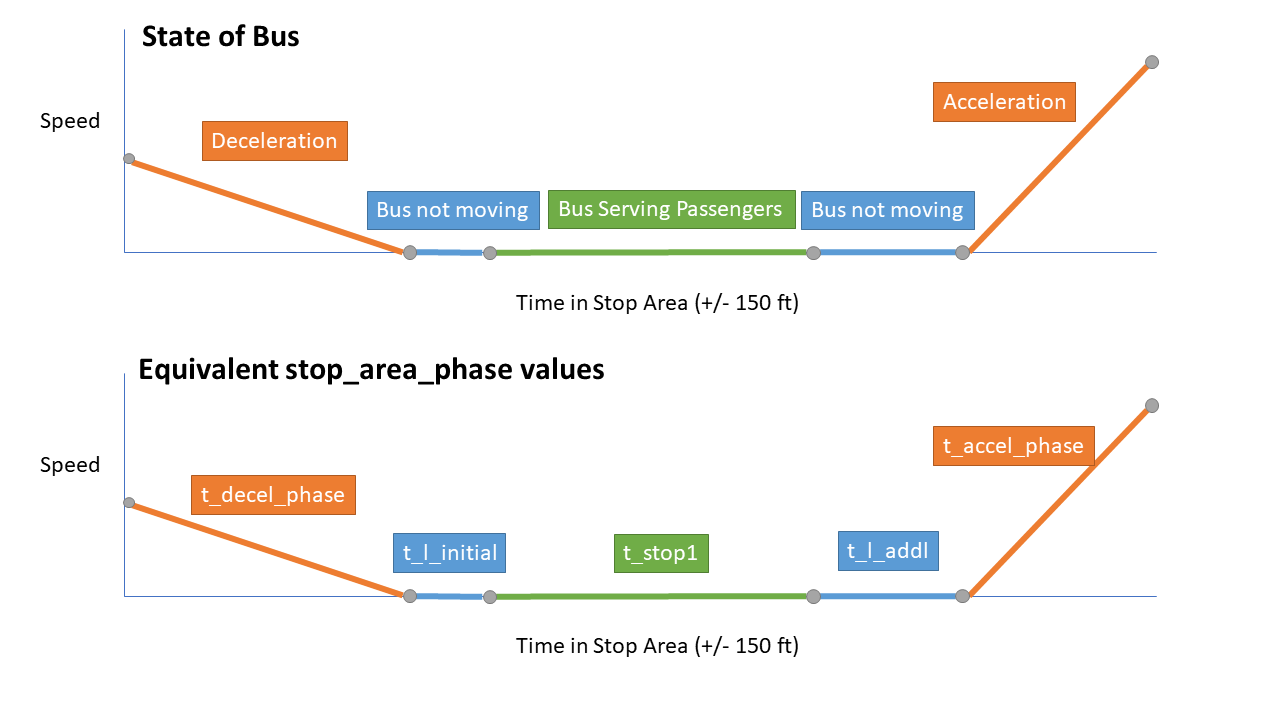

Though not shown above, two additional values can occur:
* *t_stop*: Time spent stopped for runs that do not open doors at a stop to serve passengers. It is not directly comparable to t_stop1; in runs that are otherwise identical except for the doors opening, t_stop may include time reflected in t_l_addl and t_l_initial.
* *t_nostopnopax*: Time spent in the segment for runs that do not stop whatsoever. The stop_area_phase will only include this value if applicable.

Detailed understanding of the stop area movement decomposition is best understood through a review of the code for the function `decompose_stop_area`, which is not explained in detail here. Challenges addressed in the code include:
* Identifying sequences of vehicle movement and vehicle stopping to determine when t_l_initial and t_l_addl are applicable.
* Addressing cases where rawnav ping values for the odometer and seconds elapsed repeat, resulting in undefined speeds.
* Addressing cases where the doors are recorded as open even as the marginal speed is above zero. 
* Addressing cases where the vehicle does not serve passengers and calculating the movement decomposition based on vehicle movement alone.

### 3C. Decompose Travel Time

Using the above freeflow speeds, the stop area decomposition, and other information about a run, a travel time decomposition can be completed for each run.

In [53]:
segment_ff_val = segment_ff.loc[0.95,"fps_next3"]

traveltime_decomp = (
    wr.decompose_traveltime(
        rawnav_dat,
        segment_summary_fil,
        stop_area_decomp,
        segment_ff_val
    )
)

In [67]:
traveltime_decomp.head(n=7)

,filename,index_run_start,seg_name_id,route,pattern,wday,start_date_time,flag_nostop,flag_odometer_reset,t_segment,t_stop,t_stop1,t_stop2,t_ff,t_traffic,t_l_initial,t_l_addl,t_decacc,start_odom_ft_segment,end_odom_ft_segment,trip_dist_mi_odom_and_segment,start_sec_segment,end_sec_segment,trip_dur_sec_segment,start_lat_segment,end_lat_segment,start_long_segment,end_long_segment,dist_first_stop_segment,trip_speed_mph_segment,fullpath,file_busid,file_id,taglist,route_pattern,tag_busid,end_date_time,index_run_start_original,index_run_end_original,index_run_end,sec_start,odom_ft_start,sec_end,odom_ft_end,run_duration_from_sec,run_duration_from_tags,dist_odom_mi,mph_odom,mph_run_tag,dist_crow_fly_mi,lat_start,long_start,lat_end,long_end,flag_too_far_any,flag_wrong_order_any,flag_too_long_odom,__index_level_0__,odom_ft_seg_total
0,rawnav06424171005.txt,1980.0,sixteenth_u_stub,S9,2,Wednesday,2017-10-04 07:39:47,False,False,43.0,0.0,4.0,14.247317,15.400000,9.352683,0.0,NaN,14.247317,6887.0,7580.0,0.13,613.0,656.0,43.0,38.915779,38.917670,-77.036500,-77.036513,3.24,10.99,C:\Users\WylieTimmerman\Documents\projects_loc...,6424,06424171005,"1985, S902,6424,10/04/17,07:39:47,45481,05280",S902,6424.0,2017-10-04 08:19:12,1979,3410.0,3409,0,0,2360,39101,2360,0 days 00:39:25.000000000,7.405492,11.296514,11.27,6.346457,38.901399,-77.030710,38.993290,-77.029910,False,False,False,0,693.0
1,rawnav06424171005.txt,5317.0,sixteenth_u_stub,S9,2,Wednesday,2017-10-04 09:26:40,True,False,24.0,0.0,0.0,0.000000,15.955556,8.044444,0.0,NaN,14.247317,6868.0,7586.0,0.14,575.0,599.0,24.0,38.915769,38.917719,-77.036456,-77.036458,14.21,20.40,C:\Users\WylieTimmerman\Documents\projects_loc...,6424,06424171005,"5322, S902,6424,10/04/17,09:26:40,45481,05280",S902,6424.0,2017-10-04 09:50:24,5316,6157.0,6156,1,0,1423,19110,1422,0 days 00:23:44.000000000,3.619318,9.162831,9.15,3.311794,38.901382,-77.030738,38.949134,-77.036360,False,False,False,1,718.0
2,rawnav06424171005.txt,8246.0,sixteenth_u_stub,S9,2,Wednesday,2017-10-04 11:08:52,False,False,70.0,0.0,12.0,16.247317,14.933333,26.819350,2.0,NaN,14.247317,6975.0,7647.0,0.13,571.0,641.0,70.0,38.915780,38.917662,-77.036529,-77.036518,8.82,6.55,C:\Users\WylieTimmerman\Documents\projects_loc...,6424,06424171005,"8251, S902,6424,10/04/17,11:08:52,45481,05280",S902,6424.0,2017-10-04 11:47:21,8245,9690.0,9689,0,0,2309,39109,2309,0 days 00:38:29.000000000,7.407008,11.548388,11.55,6.349333,38.901297,-77.030618,38.993230,-77.029889,False,False,False,3,672.0
3,rawnav06424171005.txt,11158.0,sixteenth_u_stub,S9,2,Wednesday,2017-10-04 12:48:21,True,False,50.0,0.0,0.0,0.000000,14.755556,35.244444,0.0,NaN,14.247317,6944.0,7608.0,0.13,567.0,617.0,50.0,38.915800,38.917665,-77.036462,-77.036501,11.60,9.05,C:\Users\WylieTimmerman\Documents\projects_loc...,6424,06424171005,"11163, S902,6424,10/04/17,12:48:21,45481,05280",S902,6424.0,2017-10-04 13:30:50,11157,12706.0,12705,0,0,2549,39051,2549,0 days 00:42:29.000000000,7.396023,10.445540,10.45,6.344963,38.901339,-77.030638,38.993209,-77.029969,False,False,False,4,664.0
4,rawnav06424171005.txt,14238.0,sixteenth_u_stub,S9,2,Wednesday,2017-10-04 14:30:38,False,False,76.0,0.0,34.0,17.247317,14.955556,9.797127,3.0,NaN,14.247317,6950.0,7623.0,0.13,655.0,731.0,76.0,38.915821,38.917667,-77.036459,-77.036458,16.72,6.04,C:\Users\WylieTimmerman\Documents\projects_loc...,6424,06424171005,"14243, S902,6424,10/04/17,14:30:38,45481,05280",S902,6424.0,2017-10-04 15:09:43,14237,15671.0,15670,0,0,2345,38995,2345,0 days 00:39:05.000000000,7.385417,11.337953,11.34,6.344572,38.901541,-77.030563,38.993406,-77.030062,False,False,False,5,673.0
5,rawnav06424171005.txt,17252.0,sixteenth_u_stub,S9,2,Wednesday,2017-10-04 16:09:06,False,False,99.0,0.0,15.0,14.247317,15.000000,54.752683,0.0,NaN,14.247317,7020.0,7695.0,0.13,916.0,1015.0,99.0,38.915832,38.917695,-77.036449,-77.036444,21.59,4.65,C:\Users\WylieTimmerman\Documents\projects_loc...,6424,06424171005,"17257, S902,6424,10/04/17,16:09:06,45481,05280",S902,6424.0,20

Portions of the output will be shown in turn to illustrate the calculation methods. The previously shown run will again be the focus.

#### t_stop2

1. The average acceleration and deceleration rates are calculated over the entire acceleration and deceleration phases, respectively. The speed over three observations is used for this calculation, rather than the speeds between a pair of observations, in order to avoid cases where undefined speeds are found at the start or end of a phase.  For the example used earlier, the run decelerates from 24.333333 feet per second to 0.764706 feet per second in 7 seconds (913 seconds to 920 seconds). This results in a deceleration value of -3.37 feet per second per second. 
2. The 95th percentile of these acceleration and deceleration speeds is found across all routes.
3. The time needed to decelarate from the segment's freeflow speed in feet per second (fps) to a stop using the given deceleration rate (fps per second) is calculated with the formula
$\frac{fps_{freeflow}}{2 \ast fpsps_{95th.percentile}}$
   The same calculation is made for acceleration.
4. This value is summed (shown below as `t_decacc`). This is an estimate of the minimum time needed to serve a stop and is applicable to all runs in a segment.
4. The `t_l_initial` value is added to the value `t_decacc` to calculate `t_stop2` for each run. If a run does not stop at all, it receives no t_stop2 value.

In [49]:
(
traveltime_decomp
.head()
#.query('filename == @case_file & index_run_start == @case_run')
.filter(
    items = [
        'filename',
        'index_run_start',
        't_l_initial',
        't_decacc',
        't_stop2'
    ]
)
)

,filename,index_run_start,t_l_initial,t_decacc,t_stop2
0,rawnav06424171005.txt,1980.0,0.0,14.247317,14.247317
1,rawnav06424171005.txt,5317.0,0.0,14.247317,0.000000
2,rawnav06424171005.txt,8246.0,2.0,14.247317,16.247317
3,rawnav06424171005.txt,11158.0,0.0,14.247317,0.000000
4,rawnav06424171005.txt,14238.0,3.0,14.247317,17.247317


#### t_ff (freeflow)

Free-flow travel time is estimated using the segment's freeflow speed and the distance traveled by a run within a segment (which will vary slightly based on where the ping nearest to the segment endpoint is found; the segment as measured is 687 feet long).

Our example case has a freeflow time of 15.38 seconds; other runs will have very similar freeflow travel time values.

In [64]:
(
traveltime_decomp
.head(n=7)
# we recalculate a few things that were dropped from the output for illustration
.assign(
    odom_ft_seg_total = lambda x: x.end_odom_ft_segment - x.start_odom_ft_segment,
    ff_fps = segment_ff_val
)
.filter(
    items = [
        'filename',
        'index_run_start',
        'start_date_time',
        't_segment',
        'start_odom_ft_segment',
        'end_odom_ft_segment',
        'odom_ft_seg_total',
        'ff_fps',
        't_ff'
    ]
)
)

,filename,index_run_start,start_date_time,t_segment,start_odom_ft_segment,end_odom_ft_segment,odom_ft_seg_total,ff_fps,t_ff
0,rawnav06424171005.txt,1980.0,2017-10-04 07:39:47,43.0,6887.0,7580.0,693.0,45.0,15.400000
1,rawnav06424171005.txt,5317.0,2017-10-04 09:26:40,24.0,6868.0,7586.0,718.0,45.0,15.955556
2,rawnav06424171005.txt,8246.0,2017-10-04 11:08:52,70.0,6975.0,7647.0,672.0,45.0,14.933333
3,rawnav06424171005.txt,11158.0,2017-10-04 12:48:21,50.0,6944.0,7608.0,664.0,45.0,14.755556
4,rawnav06424171005.txt,14238.0,2017-10-04 14:30:38,76.0,6950.0,7623.0,673.0,45.0,14.955556
5,rawnav06424171005.txt,17252.0,2017-10-04 16:09:06,99.0,7020.0,7695.0,675.0,45.0,15.000000
6,rawnav06424171005.txt,20531.0,2017-10-04 18:00:01,290.0,6880.0,7595.0,715.0,45.0,15.888889


#### t_traffic

t_traffic is calculated as a remainder of time in the segment after freeflow time, time to decelerate/accelerate around a stop, and time to serve passengers is accounted for. 

In [65]:
(
traveltime_decomp
.head(n= 7)
# we recalculate a few things that were dropped from the output for illustration
.filter(
    items = [
        'filename',
        'index_run_start',
        'start_date_time',
        't_segment',
        't_stop2',
        't_stop1',
        't_stop',
        't_ff',
        't_traffic'
    ]
)
)

,filename,index_run_start,start_date_time,t_segment,t_stop2,t_stop1,t_stop,t_ff,t_traffic
0,rawnav06424171005.txt,1980.0,2017-10-04 07:39:47,43.0,14.247317,4.0,0.0,15.400000,9.352683
1,rawnav06424171005.txt,5317.0,2017-10-04 09:26:40,24.0,0.000000,0.0,0.0,15.955556,8.044444
2,rawnav06424171005.txt,8246.0,2017-10-04 11:08:52,70.0,16.247317,12.0,0.0,14.933333,26.819350
3,rawnav06424171005.txt,11158.0,2017-10-04 12:48:21,50.0,0.000000,0.0,0.0,14.755556,35.244444
4,rawnav06424171005.txt,14238.0,2017-10-04 14:30:38,76.0,17.247317,34.0,0.0,14.955556,9.797127
5,rawnav06424171005.txt,17252.0,2017-10-04 16:09:06,99.0,14.247317,15.0,0.0,15.000000,54.752683
6,rawnav06424171005.txt,20531.0,2017-10-04 18:00:01,290.0,0.000000,0.0,0.0,15.888889,274.111111


#### Notes on Decomposition 

The the table above illustrates how t_traffic can vary widely across individual runs -- as high as 274 seconds in the final case. 

Before using this data for analysis, additional considerations must be made:

* Extremely high values of t_traffic or total time t_segment may indicate another issue with a run beyond traffic delay alone. Such runs may need to be removed.
* Similarly, t_traffic can possibly indeed be *negative* using this decomposition method, though it is unlikely. This will be the case for runs that maintain travel faster than the 95th percentile freeflow speed in the segment.

In [70]:
(
traveltime_decomp
    .sort_values(
        by = ['t_traffic'], 
        ascending = True
    )
    .filter(
        items = [
            'filename',
            'index_run_start',
            'start_date_time',
            't_segment',
            't_stop2',
            't_stop1',
            't_stop',
            't_ff',
            't_traffic'
        ]
    )
)

,filename,index_run_start,start_date_time,t_segment,t_stop2,t_stop1,t_stop,t_ff,t_traffic
59,rawnav06429171019.txt,7413.0,2017-10-18 10:48:50,17.0,0.000000,0.0,0.0,15.244444,1.755556
34,rawnav06427171026.txt,5227.0,2017-10-25 09:17:00,17.0,0.000000,0.0,0.0,15.222222,1.777778
198,rawnav06445171026.txt,13513.0,2017-10-25 14:10:40,18.0,0.000000,0.0,0.0,15.711111,2.288889
195,rawnav06445171026.txt,4679.0,2017-10-25 09:11:14,19.0,0.000000,0.0,0.0,16.288889,2.711111
310,rawnav06461171005.txt,23089.0,2017-10-04 21:06:36,41.0,16.247317,6.0,0.0,15.288889,3.463794
42,rawnav06428171026.txt,14075.0,2017-10-25 13:50:52,38.0,14.247317,5.0,0.0,15.000000,3.752683
111,rawnav06437171005.txt,14927.0,2017-10-04 19:45:32,39.0,16.247317,4.0,0.0,14.955556,3.797127
172,rawnav06443171005.txt,8137.0,2017-10-04 10:27:01,20.0,0.000000,0.0,0.0,16.044444,3.955556
117,rawnav06437171012.txt,14010.0,2017-10-11 14:09:03,46.0,16.247317,10.0,0.0,15.577778,4.174905
238,rawnav06451171026.txt,1927.0,2017-10-25 07:38:00,43.0,14.247317,9.0,0.0,15.266667,4.486016
